In [1]:
# 전이학습(Transfer Learning)을 구현해 보아요!
# 사용하는 Pretrained Network(Model)은 VGG16을 이용할꺼예요!
# 데이터는 개와 고양이 이진분류 예제를 사용할꺼고
# 이미지의 pixel 데이터 추출할때는 ImageDataGenerator를 이용할꺼예요!
# Augmentation(증식)까지 포함해서 구현해 보아요!

# 필요한 module import
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [2]:
# Raw Data Loading => 원래는 이거였는데 이번에는
# ImageDataGenerator를 이용해서 데이터 처리를 할꺼예요!

train_dir = 'C:/Users/user/Desktop/my_ws/edu/deeplearning/23_12_18/cat_dog_small/train'
validation_dir = 'C:/Users/user/Desktop/my_ws/edu/deeplearning/23_12_18/cat_dog_small/validation'

# ImageDataGenerator 객체를 설정잡아서 생성해요!
# 두개의 설정을 해요. 하나는 정규화 설정, 다른하나는 증식
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# validation data는 당연히 증식을 사용하면 안되요!
validation_datagen = ImageDataGenerator(rescale=1/255)

# 각 ImageDataGenerator객체가 어떻게 동작하는지 그 설정을 잡아야 해요!
train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],  # label처리!
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],  # label처리!
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
# 데이터 준비가 끝났으면 이제 Model을 생성해야 해요!
# 우리는 CNN모델을 처음부터 끝까지 만드는게 아니예요!
# Feature Extraction부분은 VGG16을 이용해서 사용하구요!
# 뒤쪽에 classifier부분만 우리가 직접 구현할꺼예요!

# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224,224,3))

model_base.trainable = False   # Convolution Layer 동결!

# model_base.summary()
# input_1 (InputLayer)        [(None, 224, 224, 3)]     0
# 이 모델은 입력으로 (224,224,3) 형태를 받아요!
# 이미지 1장이 결국 (7, 7, 512) 형태로 변환되요!
# 기본적으로는 classifier가 포함되어 있어요!
# classifier는 사용할 수 없으니 제거해야 해요!

# Total params: 14714688 (56.13 MB) => 전체 파라미터의 수
# Trainable params: 14714688 (56.13 MB) => 학습할때 갱신되는 파라미터의 수
# ==> epoch이 진행될때 자동으로 update되는 파라미터의 수
# ==> 이렇게 두면 안되요.. 학습이 안되도록 처리해야 해요!
# ==> 이렇게 되야 해요! Non-trainable params: 14714688 (56.13 MB)


# 모델을 완성하면 되요!
model = Sequential()

model.add(model_base)  # 우리 모델의 앞부분에 pretrained network을 삽입!

# classifier를 구현

model.add(Flatten())

# Hidden Layer
model.add(Dense(units=512,
                activation='relu'))

model.add(Dropout(rate=0.5))

# Output Layer
model.add(Dense(units=1,
                activation='sigmoid'))

# model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/30
100/100 [==============================] - 33s 226ms/step - loss: 0.5338 - acc: 0.7345 - val_loss: 0.4722 - val_acc: 0.7630
Epoch 2/30
100/100 [==============================] - 23s 230ms/step - loss: 0.3603 - acc: 0.8430 - val_loss: 0.2831 - val_acc: 0.8780
Epoch 3/30
100/100 [==============================] - 21s 213ms/step - loss: 0.2988 - acc: 0.8645 - val_loss: 0.2326 - val_acc: 0.9040
Epoch 4/30
100/100 [==============================] - 22s 221ms/step - loss: 0.2692 - acc: 0.8750 - val_loss: 0.2066 - val_acc: 0.9130
Epoch 5/30
100/100 [==============================] - 22s 218ms/step - loss: 0.2647 - acc: 0.8900 - val_loss: 0.1953 - val_acc: 0.9200
Epoch 6/30
100/100 [==============================] - 20s 202ms/step - loss: 0.2607 - acc: 0.8915 - val_loss: 0.1923 - val_acc: 0.9200
Epoch 7/30
100/100 [==============================] - 19s 189ms/step - loss: 0.2445 - acc: 0.8895 - val_loss: 0.2278 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 1

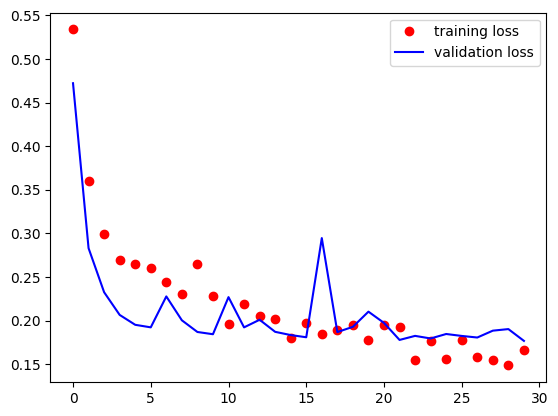

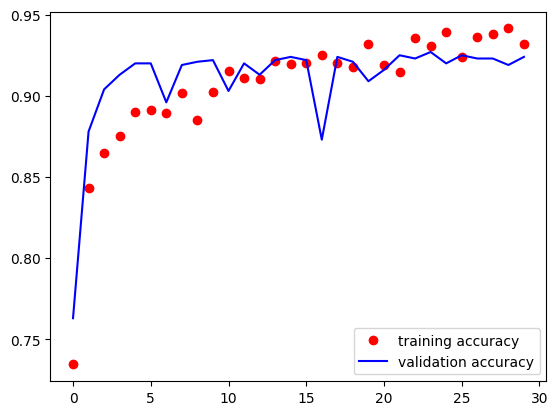

In [4]:
# 학습이 끝난 다음에는 당연히 시각화해서 overfitting이 발생하는지 확인을
# 해야 해요!
# loss와 val_loss, acc와 val_acc를 비교해서 overfitting의 정도를 확인하면 되요!
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['acc']
valid_acc = history.history['val_acc']

plt.plot(train_loss,
         'o',
         color='r',
         label='training loss')
plt.plot(valid_loss,
         color='b',
         label='validation loss')
plt.legend()
plt.show()

plt.plot(train_acc,
         'o',
         color='r',
         label='training accuracy')
plt.plot(valid_acc,
         color='b',
         label='validation accuracy')
plt.legend()
plt.show()


In [5]:
# 우리가 학습한 모델을 일단 파일로 저장해 놓아요!
model.save('cat_dog_small/12.19.CNN_model.h5')

In [6]:
# Fine Tuning
# 이미 위쪽에서 학습이 한번 끝났기 때문에 여기에 추가적으로
# 상위 convolution layer의 동결을 풀고 학습을 한번더 수행하면 되요!

# 먼저 파일로 저장되어 있는 model을 loading해요!
# from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/[AI_SCHOOL_9기]/data/cat_dog_small/12.19.CNN_model.h5')

# model.summary()

# 여기까지가 한번 Transfer Learning을 이용해서 학습이 완료된 상태예요!
# 추가적인 작업이 필요한데.. 일부 layer에 대한 동결을 해제해야 해요!
# Pretrained Network
model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224,224,3))

model_base.trainable = False   # Convolution Layer 동결!

for layer in model_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
        layer.trainable = True  # 이렇게 하면 해당 layer의 동결이 풀려야 되요!
    else:
        layer.trainable = False

# 이렇게 모델을 다시 만들고 학습을 한번 더 진행하면 되요!
# => fine tuing! (큰 변화는 아니지만 어느정도 모델의 정확도를 올릴 수 있어요!)

model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# IMDB Review Data Set을 Loading해 보아요!
# tensorflow keras에는 이미 정수로 바꾼 Review 데이터가 포함되어 있어요!
# 가장 많이 등장하는 단어 500개만 vocabulary로 사용해서 데이터를 적재할 꺼예요!

from tensorflow.keras.datasets import imdb

(x_data_train, t_data_train) , (x_data_test, t_data_test) = \
imdb.load_data(num_words=500)

17465344/17464789 [==============================] - 1s 0us/step


(25000,)
(25000,)
(25000,)
(25000,)
[1 0 0 1 0 0 1 0 1 0]
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
<class 'numpy.ndarray'>
<class 'list'>
218
189
[218 189 141 550 147  43 123 562 233 130]
238.

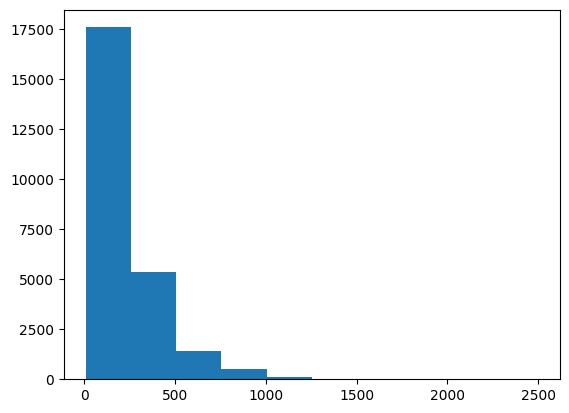

<class 'numpy.ndarray'>
(25000, 100)


In [8]:
# 데이터적재가 다 됬으면 이제 데이터가 어떻게 구성되는지 한번 알아보아요!
print(x_data_train.shape) # x_data_train shape => (25000,)
print(t_data_train.shape) # t_data_train shape => (25000,)

print(x_data_test.shape) # x_data_test shape => (25000,)
print(t_data_test.shape) # t_data_test shape => (25000,)

# 일단 train data : 25,000, test data : 25,000개 있어요!
# t_data_train 내용을 살짝보면
print(t_data_train[:10])  # [1 0 0 1 0 0 1 0 1 0]  0은부정, 1은긍정의 의미
print(x_data_train[0]) # 이 안에 들어있는게 python 리스트예요!
print(type(x_data_train))  # <class 'numpy.ndarray'>
print(type(x_data_train[0]))  # <class 'list'>

# 첫번째 review의 길이(첫번째 Review는 몇개의 단어로 구성되어 있나요?)
print(len(x_data_train[0]))  # 218
# 두번째 review의 길이(두번째 Review는 몇개의 단어로 구성되어 있나요?)
print(len(x_data_train[1]))  # 189

# padding에 대해서 살짝 알아보아요!
# 각 Review의 길이에 대해서 알아보아요!
import numpy as np
import matplotlib.pyplot as plt

lengths = np.array([len(x) for x in x_data_train])
print(lengths[:10])
# [218 189 141 550 147  43 123 562 233 130]

# 모든 Review의 평균길이와 중간값을 출력해보아요!
print(np.mean(lengths))  # 238.71364
print(np.median(lengths))  # 178.0

plt.hist(lengths)
plt.show()

# 평균과 중위값과 히스토그램을 살펴본 결과
# 대부분의 review는 길이가 300 token미만인걸로 파악되요!
# 실제로는 100 token미만인 경우가 아마 대다수일꺼예요!

# 그래서 우리는 모든 Review의 길이를 100에 맞출꺼예요!
# 첫번째 경우는 100보다 리뷰길이가 긴 리뷰는 리뷰가 짤려요!
#               어디를 짜르나요? 앞쪽 데이터를 짤라요!
# 두번째 경우는 100보다 리뷰길이가 짧은 리뷰는 리뷰를 채워줘야해요! => padding
#               패딩을 당연히 앞쪽에 붙여야 겠죠.

# 이 작업을 위해서 keras가 우리에게 함수를 하나 제공해 줘요!

from tensorflow.keras.preprocessing.sequence import pad_sequences

x_data_train_seq = pad_sequences(x_data_train, maxlen=100)
print(type(x_data_train_seq))  # <class 'numpy.ndarray'>
print(x_data_train_seq.shape) # (25000, 100)
# 25,000개의 review. 각 review는 100개의 token으로 재단되었어요!